In [232]:
import numpy as np
from scipy.spatial import distance
from scipy.special import beta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets
from sklearn.linear_model import LinearRegression

In [251]:
dfs = {}

#print('MNIST')
#train = datasets.MNIST('./data/mnist/train', train=True, download=True)
#test = datasets.MNIST('./data/mnist/test', train=False, download=True)
#dfs['MNIST'] = pd.DataFrame({
#    'images': \
#        [ image for image, label in train ] + [ image for image, label in test ],
#    'labels': \
#        [ label.item() for image, label in train ] + [ label.item() for image, label in test ],
#})

#print('CIFAR10')
#train = datasets.CIFAR10('./data/mnist/train', train=True, download=True)
#test = datasets.CIFAR10('./data/mnist/test', train=False, download=True)
#dfs['CIFAR10'] = pd.DataFrame({
#    'images': \
#        [ image for image, label in train ] + [ image for image, label in test ],
#    'labels': \
#        [ label for image, label in train ] + [ label for image, label in test ],
#})

print('RANDOM10')
size=int(1e6)
# 1M random 1d pictures w/ 10px
data = torch.randn(size, 10)
#data /= data.norm(dim=1).view(-1,1).expand(data.shape)
data /= np.sqrt(10)
dfs['RANDOM10'] = pd.DataFrame({
    'images': data,
    'labels': np.random.randint(2, size=size)
})

print('RANDOM30')
size=int(1e6)
# 1M random 1d pictures w/ 30px
data = torch.randn(size, 30)
#data /= data.norm(dim=1).view(-1,1).expand(data.shape)
data /= np.sqrt(30)
dfs['RANDOM30'] = pd.DataFrame({
    'images': data,
    'labels': np.random.randint(2, size=size)
})

print('RANDOM50')
size=int(1e6)
# 1M random 1d pictures w/ 50px
data = torch.randn(size, 50)
#data /= data.norm(dim=1).view(-1,1).expand(data.shape)
data /= np.sqrt(50)
dfs['RANDOM50'] = pd.DataFrame({
    'images': data,
    'labels': np.random.randint(2, size=size)
})

print('RANDOM100')
size=int(1e6)
# 1M random 1d pictures w/ 100px
data = torch.randn(size, 100)
#data /= data.norm(dim=1).view(-1,1).expand(data.shape)
data /= np.sqrt(100)
dfs['RANDOM100'] = pd.DataFrame({
    'images': data,
    'labels': np.random.randint(2, size=size)
})

#train = datasets.ImageFolder('./data/tiny-imagenet-200/train')
#test = datasets.ImageFolder('./data/tiny-imagenet-200/test')
#dfs['TINYIMGNET'] = pd.DataFrame({
#    'images': \
#        [ image for image, label in train ] + [ image for image, label in test ],
#    'labels': \
#        [ label for image, label in train ] + [ label for image, label in test ],
#})

RANDOM10
RANDOM30
RANDOM50


RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at /opt/conda/conda-bld/pytorch_1550796191843/work/aten/src/TH/THGeneral.cpp:201

In [217]:
### USING SCIPY'S CDIST

NPS = 50
PMAX = np.inf
NSAMPLESMAX = 1000
PBREAK = 10000
nn_dens = {}

for name, df in dfs.items():
    if name == 'TINYIMGNET': continue
    print("DATASET:", name)

    Ps = [ int(i) for i in np.logspace(1, np.log10(len(df)), NPS) ]
    nn_dens[name] = {}

    for P in Ps:
        #if P >= 10000: break
        print(P, 10*'\t', end='\r')
        if P > len(dfs[name]):
            pass

        Pprime = min(P, NSAMPLESMAX) if P < PBREAK else NSAMPLESMAX*PBREAK//P#P

        x = torch.stack(list(
            dfs[name]['images'].sample(P).map(lambda x: torch.Tensor(np.asarray(x).reshape(-1,))).values
        ))
        xprime = x[np.random.choice(range(P), Pprime, replace=False)]
        d = x.shape[1]
        # dists ~ (P, Pprime): dists[i,j] == |x_i - x_j|, w/ i=1..P and j=j_1..j_Pprime
        dists = distance.cdist(x, xprime)
        dists[dists == 0] = np.inf
        nn_dens[name][P] = dists.min(axis=0)#dists.min()

DATASET: RANDOM10
DATASET: RANDOM30
DATASET: RANDOM50
DATASET: RANDOM100
DATASET: RANDOM300


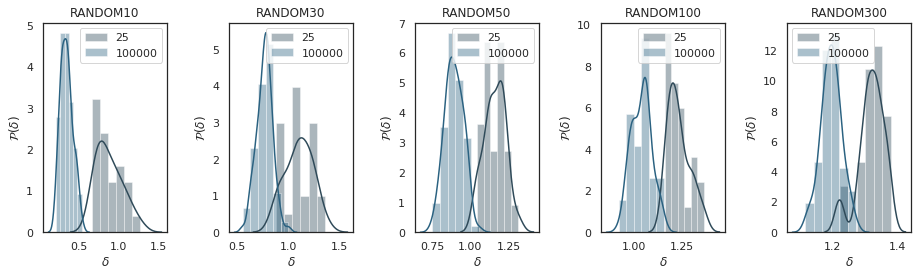

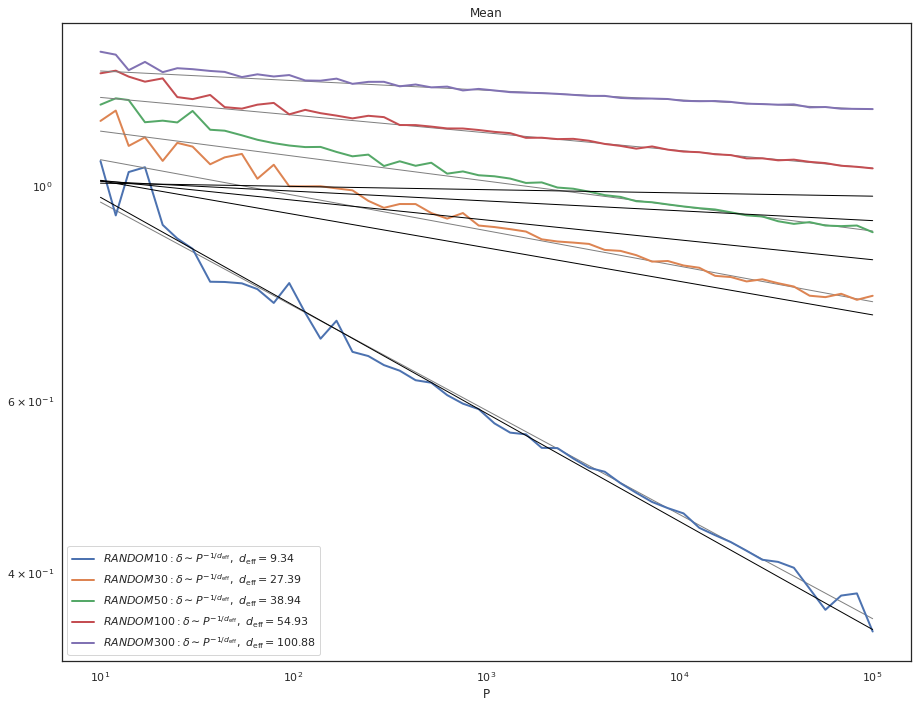

In [250]:
sns.set_palette("PuBu_d")
sns.set_style("white")
f, axes = plt.subplots(1, len(nn_dens), figsize=(13,4))

for j, (name, dict) in enumerate(nn_dens.items()):
    for i, (P, dens) in enumerate(dict.items()):
        if i != 5 and i != len(dict) - 1: continue
        sns.distplot(dens, label=str(P), kde=True, ax=axes[j], bins=6)

    axes[j].legend()
    axes[j].set_title(name)
    axes[j].set_xlabel('$\delta$')
    axes[j].set_ylabel('$\mathcal{P}(\delta)$')

plt.tight_layout()
plt.show()
sns.set()
sns.set_style("white")

plt.figure(figsize=(13,10))

for j, (name, dict) in enumerate(nn_dens.items()):
    xs = np.asarray(list(dict.keys())).reshape(-1,1)
    ys = np.asarray([ v.mean().item() for v in dict.values() ]).reshape(-1,)

    reg = LinearRegression().fit(np.log(xs[35:]), np.log(ys[35:]))
    ys0 = np.exp(reg.intercept_)*np.power(xs[0], reg.coef_) # just for normalization
    ys0=1
    plt.plot(xs, [ np.exp(reg.intercept_)*x**reg.coef_/ys0 for x in xs ], c='gray', lw=1)
    plt.plot(xs, ys/ys0, label="${}: \delta \sim P^{{-1/d_\mathrm{{eff}}}},\ d_\mathrm{{eff}}={:.2f}$".format(name, -1/reg.coef_[0]), lw=2)

    plt.legend()
    plt.xlabel("P")
    #plt.set_ylabel("$<\delta_\mathrm{min}>$")
    plt.xscale('log')
    plt.yscale('log')
    plt.title("Mean")

d=10
plt.plot(xs, [ (beta((d-1)/2,1/2)*(d-1)/x)**(1/(d-1)) for x in xs ], c='black', lw=1)
d=30
plt.plot(xs, [ (beta((d-1)/2,1/2)*(d-1)/x)**(1/(d-1)) for x in xs ], c='black', lw=1)
d=50
plt.plot(xs, [ (beta((d-1)/2,1/2)*(d-1)/x)**(1/(d-1)) for x in xs ], c='black', lw=1)
d=100
plt.plot(xs, [ (beta((d-1)/2,1/2)*(d-1)/x)**(1/(d-1)) for x in xs ], c='black', lw=1)
d=300
plt.plot(xs, [ (beta((d-1)/2,1/2)*(d-1)/x)**(1/(d-1)) for x in xs ], c='black', lw=1)

plt.tight_layout()
plt.show()